Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs
import tarfile

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, decraoff=None, unit='arcsec', axis_label=False):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal',
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    ax.grid(alpha=0.5)
    if axis_label:
        ax.set_xlabel('DEC direction')
        ax.set_ylabel('RA direction')
    return ax

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

In [5]:
band = 'g'
field = 'south'
region_name = 'decals_ngc'

if (field=='north') and ((band=='g') or (band=='r')):
    pixscale = 0.454
else:
    pixscale = 0.262

download_dir = '/Users/rongpu/Desktop/temp/dr8_ccd_cutouts'

ramin, ramax, decmin, decmax = 175, 185, -5, 0

__Load GAIA catalog__

603673
0.9783425795091051


/Users/rongpu/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


0.11029741959998618
0.10974472347922208
0.08891498842792497


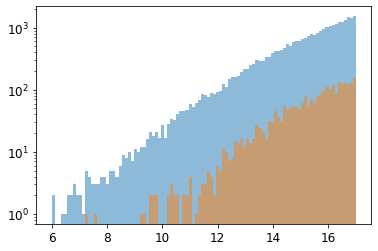

In [6]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia4.fits.gz'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

mask = np.isfinite(gaia['phot_g_mean_mag']) & np.isfinite(gaia['bp_rp'])
print(np.sum(mask)/len(mask))
gaia = gaia[mask]

mask = (gaia['ra']>ramin) & (gaia['ra']<ramax) & (gaia['dec']>decmin) & (gaia['dec']<decmax)
gaia = gaia[mask]

gaia['pm'] = np.sqrt(gaia['pmra']**2 + gaia['pmdec']**2)
gaia['pmerr'] = np.sqrt(gaia['pmra_error']**2 + gaia['pmdec_error']**2)
mask = gaia['pm']<5
print(np.sum(mask)/len(mask))
mask &= gaia['pmerr']<1
print(np.sum(mask)/len(mask))
mask &= gaia['astrometric_excess_noise']==0
print(np.sum(mask)/len(mask))

plt.hist(gaia['phot_g_mean_mag'], 100, range=(6, 17), log=True, alpha=0.5)
plt.hist(gaia['phot_g_mean_mag'][mask], 100, range=(6, 17), log=True, alpha=0.5)
plt.show()

gaia = gaia[mask]

In [7]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for bandtmp in ['g', 'r', 'z']:
    if field=='north':
        tmp = Table.read('../data/gaia_bassmzls_transform.txt', format='ascii.commented_header')
    else:
        tmp = Table.read('../data/gaia_decals_transform.txt', format='ascii.commented_header')
    transform_interp[bandtmp] = interp1d(tmp['bp_rp'], tmp['ls_'+bandtmp], bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['ls_'+bandtmp] = gaia['phot_g_mean_mag'] + transform_interp[bandtmp](gaia['bp_rp'])

__Load CCD table__

In [8]:
ccd_columns = ['image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec']

# surveyccd_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/'
surveyccd_dir = '/Users/rongpu/Documents/Data/desi_misc/dr8'

if field=='south':
    ccd = fitsio.read(os.path.join(surveyccd_dir, 'survey-ccds-decam-dr8.fits.gz'), columns=ccd_columns)
elif field=='north' and band=='z':
    ccd = fitsio.read(os.path.join(surveyccd_dir, 'survey-ccds-mosaic-dr8.fits.gz'), columns=ccd_columns)
elif field=='north' and (band=='g' or band=='r'):
    ccd = fitsio.read(os.path.join(surveyccd_dir, 'survey-ccds-90prime-dr8.fits.gz'), columns=ccd_columns)
else:
    raise ValueError
ccd = Table(ccd)
ccd[:1]

image_hdu,camera,expnum,ccdname,filter,fwhm,ra,dec
int16,str9,int64,str5,str1,float32,float64,float64
1,decam,229341,S29,g,5.310411,318.0503245041465,1.7030645111876705


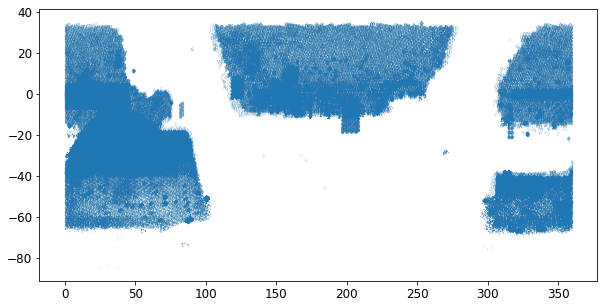

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
plt.show()

__Load polynomial fit__

In [10]:
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale = 0.454
else:
    pixscale = pixscale

tmp = np.loadtxt('../data/{}_poly_fit.txt'.format(region_name))
band_index = np.where(band==np.array(['g', 'r', 'z']))[0][0]
poly = np.poly1d(tmp[band_index])
print(poly)
profile_fit = np.poly1d(poly)

        5          4         3         2
-0.077 x - 0.2577 x + 1.984 x - 2.181 x - 3.396 x - 2.231


__Check that the fit works__

In [11]:
# ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]
# ls_mag_bright = 6.5

# profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, region_name, band), format='ascii.commented_header')
# indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, region_name, band))

# profile_bright = Table.read('../data/average_profiles_{}_{}_{}-bright.txt'.format(field, region_name, band), format='ascii.commented_header')
# indiv_bright = Table.read('../data/individual_profiles_{}_{}_{}-bright.fits'.format(field, region_name, band))

# xfit = np.logspace(-1, 2, 200)
# yfit = 10**(profile_fit(np.log10(xfit)))

# plt.figure(figsize=(11, 8))
# plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
#            label='fit', c='C0')
# # for index in range(len(ls_mag_bins)):
# for index in [0, 2, 4]:
#     # normalize the flux to 22.5 magnitude stars
#     norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale**2
#     x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
#     y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
#     plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
#                label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
# norm = 10**((ls_mag_bright-22.5)/2.5) * pixscale**2
# x = profile_bright['radius_{}_{:.2f}'.format(band, ls_mag_bright)]
# y = norm * profile_bright['flux_{}_{:.2f}'.format(band, ls_mag_bright)]
# plt.loglog(x, y, lw=1.5, alpha=1., ls=':',
#            label='{}mag = {:.2f}'.format(band, ls_mag_bright), c='r')
# plt.title('{} {} {}-band'.format(field, region_name, band))
# plt.axis([0.5, 80, 1e-9, 5e-2])
# plt.grid(alpha=0.5)
# plt.xlabel('Radius (arcsec)')
# plt.ylabel('SB (a.u.)')
# plt.legend()
# plt.show()

--------

In [22]:
which_star = 0

# mask = (gaia['phot_g_mean_mag']>10) & (gaia['phot_g_mean_mag']<11)
mask = (gaia['ls_g']>17.45) & (gaia['ls_g']<17.55)
print(np.sum(mask))
gaia_index = np.where(mask)[0][which_star]
ra, dec = gaia['ra'][gaia_index], gaia['dec'][gaia_index]
print(gaia['phot_g_mean_mag'][gaia_index])
print(ra, dec)

46
16.428022
178.59615695186454 -4.659478892899435


In [13]:
gaia[[gaia_index]]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val,pm,pmerr,ls_g,ls_r,ls_z
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag,mas / yr,mas / yr,mag,mag,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32,float64,float64,float64,float64,float64
3599363330568437248,178.59615695186454,0.06689896863326104,-4.659478892899435,0.04314812275449881,1.551296985725139,0.08511790433884962,-0.21488912901723647,0.14556536031285058,4.370498986651483,0.08714779357063315,0.0,16.428022,1.5923271,nan,nan,NOT_AVAILABLE,4419.42,0.3192,4.3757786427207925,0.16965851598796833,17.474212599294614,16.286872095078845,15.648981776823376


In [14]:
size_str = '50' # 200 is the maximum cutout size

file_path = os.path.join(download_dir, field, '{}_{}.tgz'.format(gaia['source_id'][gaia_index], size_str))
if not os.path.exists(os.path.dirname(file_path)):
    os.makedirs(os.path.dirname(file_path))

if not os.path.isfile(file_path):
    url = 'http://legacysurvey.org/viewer/cutouts-tgz/?ra={:f}&dec={:f}&size={}&layer=dr8-{}'.format(ra, dec, size_str, field)
    cmd = 'wget -O '+file_path+' \"'+url+'\"'
    print(cmd)
    os.system(cmd)
    
# # decompress .tar.gz file
# cmd = 'tar -xzvf ' + file_path + ' -C ' + os.path.dirname(file_path)
# os.system(cmd)
tar = tarfile.open(file_path)
tar.extractall(path=os.path.dirname(file_path))
# img_dir = os.path.join(os.path.dirname(file_path), 'data_{:.4f}_{:.4f}'.format(ra, dec))
img_dir = os.path.join(os.path.dirname(file_path), tar.getnames()[0])

In [15]:
ccd1 = Table.read(os.path.join(img_dir, 'ccds.fits'))
ccd1 = ccd1[ccd1['filter']==band]
ccd1.sort('image_filename')
print(len(ccd1))

ccd1_index = 0
expnum_str = str(ccd1['expnum'][ccd1_index])
fn_prefix = ccd1['camera'][ccd1_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+str.rstrip(ccd1['ccdname'][ccd1_index])
print(fn_prefix)

3
decam-00535536-N17


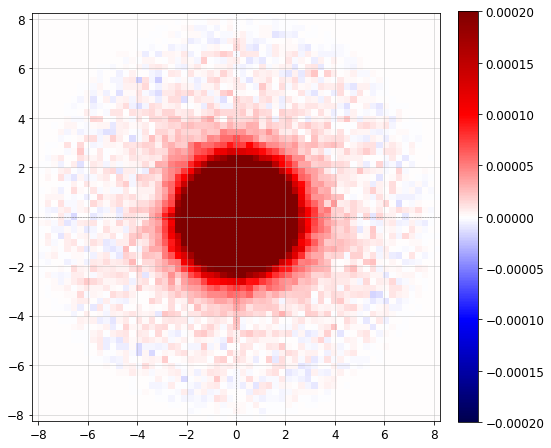

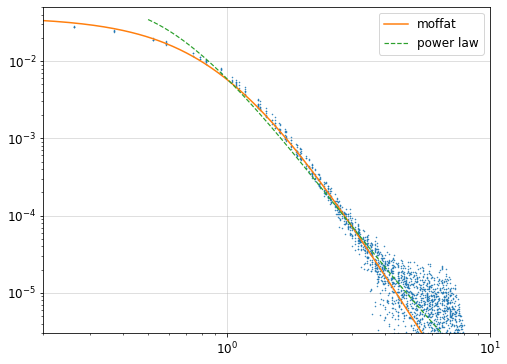

In [16]:
########## PSFEx ###########
fn = os.path.join(img_dir, fn_prefix+'-psfex.fits')
hdu = fits.open(fn)
data = hdu[1].data

psf0 = data['psf_mask'][0, 0]
vrange = 0.0002
ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange)
plt.show()

grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
xx, yy = np.meshgrid(grid, grid)
radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()

################# Moffat fit ##############
mask = radius<5.5
radius_fit = radius[mask]
psf_fit = (psf0).flatten()[mask]

radius_arr = np.arange(0, 4.5, 0.2)
flux_frac = np.zeros(len(radius_arr))
for index in range(len(radius_arr)):
    flux_frac[index] = np.sum(psf_fit[radius_fit<radius_arr[index]])/np.sum(psf_fit)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    popt, pcov = curve_fit(get_frac_moffat, radius_arr, flux_frac)
    # print(popt)

alpha, beta = popt
flux_frac_fit = get_frac_moffat(radius_arr, alpha, beta)
psf_moffat_fit = pixscale**2 * get_sb_moffat(radius_arr, alpha, beta)

radius_plot = np.linspace(0, 10, 1000)
psf_moffat_plot = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 6))
    plt.loglog(radius, (psf0).flatten(), '.', ms=1.)
    plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
    mask = radius_plot>0.5
    plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], '--', lw=1.2, label='power law')
    plt.axis([0.2, 10, 3e-6, 0.05])
    plt.grid(alpha=0.5)
    # plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum, ccdname, alpha, beta))
    plt.legend()
    plt.show()
    
# ############ Compare the PSFEx image with the other (original) set ##############

# ccd_index = np.where((ccd['expnum']==535541) & (ccd['ccdname']==ccd1['ccdname'][ccd1_index]))[0][0]
# print(ccd_index)

# expnum = ccd['expnum'][ccd_index]
# ccdname = ccd['ccdname'][ccd_index]

# print('{} {} {}; FWHM = {:.2f}'.format(expnum, ccdname, ccd['filter'][ccd_index], pixscale*ccd['fwhm'][ccd_index]))

# expnum_str = str(expnum)
# if field=='south':
#     fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged/{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str)
# elif field=='north' and band=='z':
#     fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/mosaic/psfex-merged/{}/mosaic-{}.fits'.format((5-len(expnum_str[:-3]))*'0'+expnum_str[:-3], (8-len(expnum_str))*'0'+expnum_str)
# elif field=='north' and (band=='g' or band=='r'):
#     fn = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/90prime/psfex-merged/{}/90prime-{}.fits'.format(expnum_str[:5], (8-len(expnum_str))*'0'+expnum_str)
# else:
#     raise ValueError
# hdu = fits.open(fn)
# data = hdu[1].data

# which_ccd = np.where(data['ccdname']==ccdname)[0][0]
# psf = data['psf_mask'][which_ccd]

# psf0 = psf[0]
# plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange)
# plt.show()

(50, 50)
0.99211013
24.731113740748697 23.749597784619638


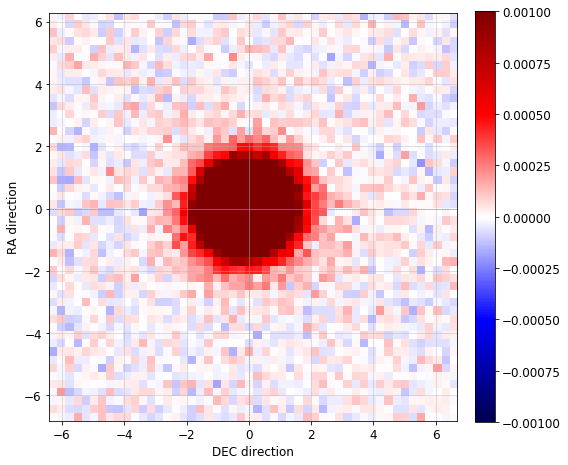

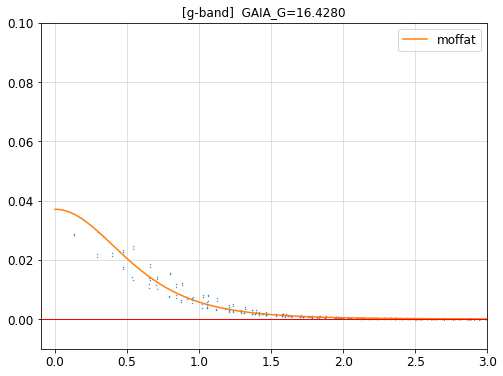

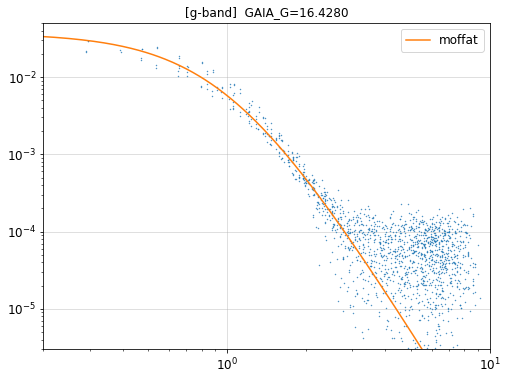

In [19]:
########## image ###########
fn = os.path.join(img_dir, fn_prefix+'-image.fits')
hdulist = fits.open(fn)
fn = os.path.join(img_dir, fn_prefix+'-weight.fits')
weights = fits.open(fn)[1].data

img = hdulist[1].data
print(img.shape)
if np.abs(img.shape[0]-img.shape[1])>1:
    raise ValueError('bad image!')
    
img[weights<=0] = np.nan
# img = img.T # transpose so that the x-axis corresponds to RA

# normalize to nanomaggie per pixel
img = img / 10**((ccd1['ccdzpt'][ccd1_index]-22.5)/2.5) / ccd1['exptime'][ccd1_index]
# normalize to a 22.5 magnitude star
img = img * 10**((gaia['ls_'+band][gaia_index]-22.5)/2.5)
print(np.sum(img[np.isfinite(img)]))

xgrid = pixscale * np.linspace(-0.5*(img.shape[1]-1), 0.5*(img.shape[1]-1), img.shape[1])
ygrid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
xx, yy = np.meshgrid(xgrid, ygrid)

# astrometric correction
ccdraoff, ccddecoff = -ccd1['ccdraoff'][ccd1_index], -ccd1['ccddecoff'][ccd1_index]

############ CANNOT DO USE THIS WHEN TRANSPOSED #############
w = wcs.WCS(hdulist[1].header)
xpixcenter, ypixcenter = w.wcs_world2pix([[ra, dec]], True)[0]
print(xpixcenter, ypixcenter)
ccddecoff += pixscale*(xpixcenter-(img.shape[1]/2+0.5))
ccdraoff += pixscale*(ypixcenter-(img.shape[0]/2+0.5))

xx, yy = xx - ccddecoff, yy - ccdraoff

mask = np.isfinite(img.flatten())
radius = np.sqrt(xx**2 + yy**2).flatten()[mask]
flux = img.flatten()[mask]

vrange = 0.001
ax = plot_cutout(img, pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange, axis_label=True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(radius, flux, '.', ms=0.8)
plt.plot(radius_plot, psf_moffat_plot, '-', label='moffat')
plt.legend()
plt.axis([-0.1, 3, -0.01, 0.1])
plt.axhline(0, lw=1, color='r')
plt.grid(alpha=0.5)
plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][gaia_index]))
plt.show()

plt.figure(figsize=(8, 6))
plt.loglog(radius, flux, '.', ms=0.8)
plt.loglog(radius_plot, psf_moffat_plot, '-', label='moffat')
plt.axis([0.2, 10, 3e-6, 0.05])
plt.grid(alpha=0.5)
plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][gaia_index]))
plt.legend()
plt.show()

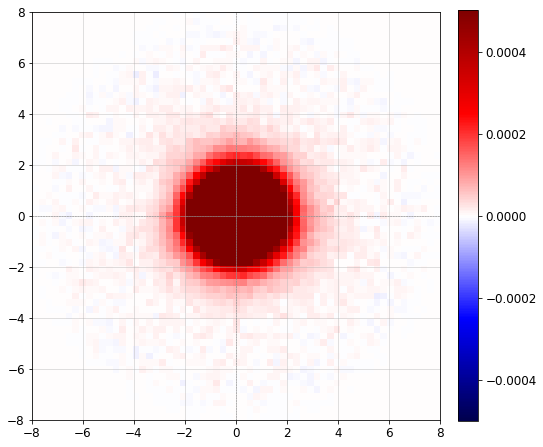

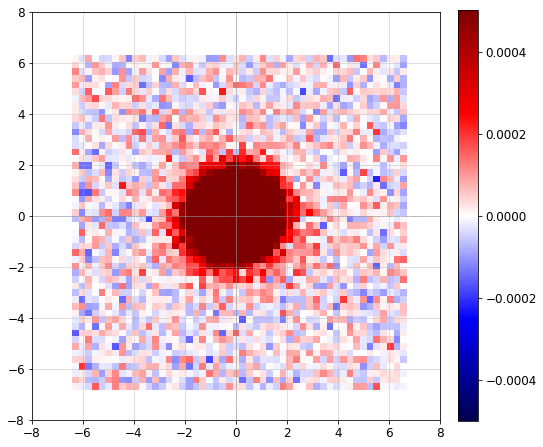

In [20]:
vrange = 0.0005

ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange)
plt.axis([-8, 8, -8, 8])
plt.show()

ax = plot_cutout(img, pixscale, decraoff=[ccddecoff, ccdraoff], vmin=-vrange, vmax=vrange)
plt.axis([-8, 8, -8, 8])
plt.show()